In [1]:
import pandas as pd
import numpy as np

from helper import plot_sample_images
from Models.VGG import VGG16, VGG19
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D, BatchNormalization, Activation, Dropout, Flatten
from tensorflow.keras.initializers import glorot_normal, he_normal
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import Model

SEED = 42
tf.random.set_seed(SEED)

## Use Node 70 -> MI100 X 4
devices =tf.config.list_physical_devices('GPU') 
strategy = tf.distribute.MirroredStrategy()
print('Number of devices: {}'.format(strategy.num_replicas_in_sync))

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')
Number of devices: 4


In [2]:
df_train, df_test = pd.read_csv('./Train.csv'), pd.read_csv('./Test.csv')
print(f"Training Data Shape:  {df_train.shape}\nTest Data Shape:      {df_test.shape}")

img_h, img_w = 512, 512
input_shape = (img_h, img_w, 3)

le = LabelEncoder()
df_train['class_encoded'] = le.fit_transform(df_train['class'])
df_train['filename'] = df_train['Image_ID'] + ".jpg"
df_train['bbox'] = df_train.apply(lambda row: [row['xmin'] / float(img_w), row['ymin'] / float(img_h), (row['xmin'] + row['width']) / float(img_h) , (row['ymin'] + row['height']) / float(img_h)], axis=1)

# Append file extensions
df_test['filename'] = df_test['Image_ID'] + ".jpg"

# plot_sample_images(df_train, top_n = 10)

Training Data Shape:  (3906, 6)
Test Data Shape:      (931, 1)


In [3]:
def get_model(plot=False, show_summary=False):
    he = he_normal(seed=SEED)
    xavier = glorot_normal(seed=SEED)
    adam = Adam(learning_rate=1e-4)
    
    input_layer = Input(shape=input_shape)

    base_layer = VGG19(input_layer)

    class_flatten = Flatten()(base_layer)
    class_dropout1 = Dropout(0.4)(class_flatten)
    class_dense1 = Dense(512, activation="elu", kernel_initializer=he)(class_dropout1)
    class_dropout2 = Dropout(0.4)(class_dense1)
    class_dense2 = Dense(256, activation="elu", kernel_initializer=he)(class_dropout2)
    class_output = Dense(3, activation='Softmax', kernel_initializer=xavier, name='class_output')(class_dense2)
    
    bbox_flatten = Flatten()(base_layer)
    bbox_dense1 = Dense(128, activation="elu", kernel_initializer=he)(bbox_flatten)
    bbox_dense2 = Dense(64, activation="elu", kernel_initializer=he)(bbox_dense1)
    bbox_dense3 = Dense(32, activation="elu", kernel_initializer=he)(bbox_dense2)
    bbox_output = Dense(4, activation='sigmoid', kernel_initializer=xavier, name='bbox_output')(bbox_dense3)

    model = Model(inputs=input_layer,
              outputs = [class_output, bbox_output]
             )

    model.compile(
        optimizer=adam,
        loss={
            'class_output' : 'sparse_categorical_crossentropy',
            'bbox_output' : 'mean_squared_error',
        },
        metrics={
            'class_output':['accuracy'],
            'bbox_output':['mean_squared_error'],
        },
        loss_weights={
            'class_output' : 1,
            'bbox_output' : 2,
        },
    )
    
    if plot:
        display(tf.keras.utils.plot_model(model, show_shapes=False, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=60))
    if show_summary:
        model.summary()
    
    return model

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


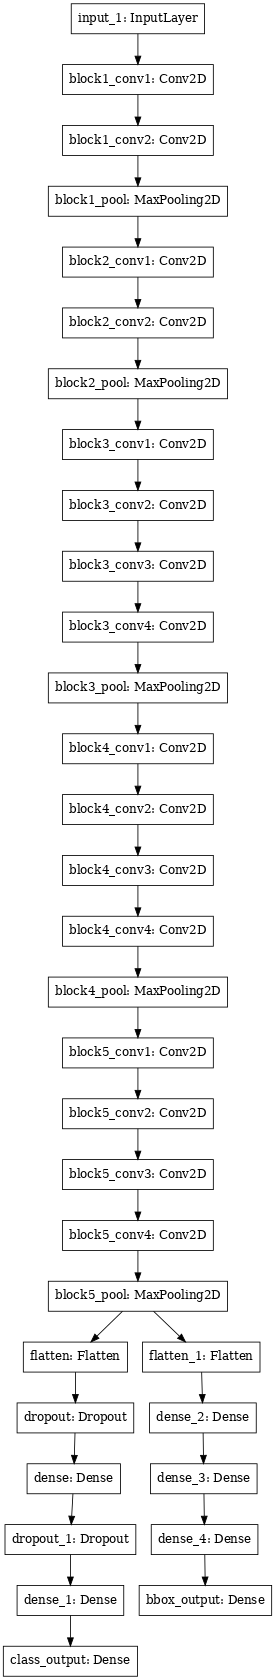

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 512, 512, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 512, 512, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 256, 256, 64) 0           block1_conv2[0][0]               
______________________________________________________________________________________________

In [4]:
with strategy.scope():
    model = get_model(plot=True)
# model = get_model(plot=True)

model.summary()

In [5]:
batch_size = 64
        
generator_with_preprocessing = ImageDataGenerator(
    rescale=1. / 255,
    validation_split=0.25,
#     featurewise_center= True,
#     featurewise_std_normalization = True,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

train_datagen = generator_with_preprocessing.flow_from_dataframe(
    dataframe=df_train,
    directory='./Train_Images/',
    x_col='filename',
    y_col=['class_encoded', 'bbox'],
    class_mode='multi_output',
    color_mode="rgb",
    subset="training",
    shuffle=True,
    batch_size=batch_size,
    target_size = input_shape[:2],
    seed = SEED
)

val_datagen = generator_with_preprocessing.flow_from_dataframe(
    dataframe=df_train,
    directory='./Train_Images/',
    x_col='filename',
    y_col=['class_encoded', 'bbox'],
    class_mode='multi_output',
    color_mode="rgb",
    subset="validation",
    shuffle=True,
    batch_size=batch_size,
    target_size = input_shape[:2],
    seed = SEED
)

test_datagen = ImageDataGenerator(rescale=1. / 255).flow_from_dataframe(
    dataframe=df_test,
    directory='./Test_Images/',
    x_col='filename',
    y_col=None,
    class_mode=None,
    shuffle=False,
    batch_size=35,
    target_size = input_shape[:2],
)

Found 2930 validated image filenames.
Found 976 validated image filenames.
Found 931 validated image filenames.


In [6]:
epochs = 150
steps_per_epoch = 46
validation_steps = 16
n_workers = 128

earlystopping = EarlyStopping(monitor='val_class_output_accuracy', patience=20, min_delta=1e-4, verbose=1, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, verbose=1, mode='auto', min_lr=1e-6)
checkpoints = ModelCheckpoint(filepath='./Checkpoints/best.hdf5', monitor='val_class_output_accuracy', verbose=1, save_best_only=True, save_weights_only=True )

hist = model.fit(train_datagen,
                epochs=epochs,
                steps_per_epoch=steps_per_epoch,
                validation_data=val_datagen,
                validation_steps=validation_steps,
                max_queue_size=n_workers * 4,
                workers=n_workers,
                                callbacks=[
                                    earlystopping,
                                    checkpoints, 
                                    reduce_lr
                                ],
                            )

Epoch 1/150
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:batch_all_reduce: 46 all-reduces with algorith

In [7]:
label_pred, bbox_pred = model.predict(test_datagen, steps=27, workers=n_workers)

df_test['class'] = le.inverse_transform(np.argmax(label_pred, axis=1))
df_test['confidence'] = np.max(label_pred, axis=1)
df_test['ymin'] = bbox_pred[:, 1] * img_h
df_test['xmin'] = bbox_pred[:, 0] * img_w
df_test['ymax'] = bbox_pred[:, 3] * img_h
df_test['xmax'] = bbox_pred[:, 2] * img_w
df_test['width'] = df_test['xmax'] - df_test['xmin']
df_test['height'] = df_test['ymax'] - df_test['ymin']

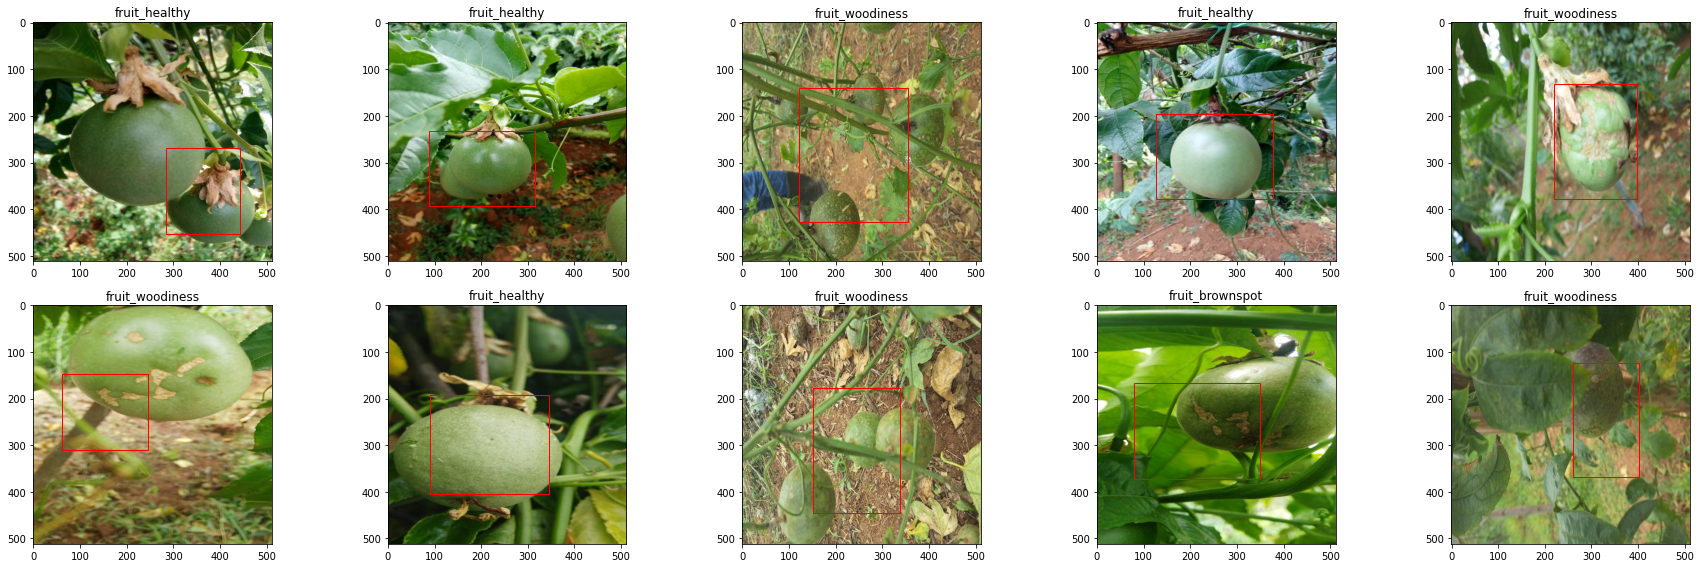

In [8]:
plot_sample_images(df_test, top_n = 10, is_train=False)

In [9]:
df_test[['Image_ID', 'class', 'confidence', 'ymin', 'xmin', 'ymax', 'xmax']].to_csv('submission.csv', index=False)